# Лабораторная работа Классификация *kNN*

The dataset includes 1500 rows and 7 columns:

is_genuine: boolean
diagonal: float
height_left: float
height_right: float
margin_low: float
margin_upper: float
length: float
Idea of projects with this dataset:

Predicting the missing values with a linear regression or a KNN imputer
Comparing classification such as logistic regression or KNN with an unsupervised model such as K-Means to predict the authenticity of the bills
Trying to do a PCA or a Kernel Transform to create a clearer separation between the Genuine and Fake Bills

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1. Load the dataset
df = pd.read_csv('fake_bills.csv', sep=';')

## Бинарная классификация (is_open)


### Предобработка данных

In [4]:
# 2.1 Preprocessing
print("\nBinary Classification Preprocessing:")
# Check for missing values
print("Missing values:\n", df.isnull().sum())
# Fill missing values in 'margin_low' with median
df['margin_low'] = df['margin_low'].fillna(df['margin_low'].median())
# Verify no missing values
print("Missing values after filling:\n", df.isnull().sum())



Binary Classification Preprocessing:
Missing values:
 is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64
Missing values after filling:
 is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


### Обучение без нормализации

In [5]:
# 2.2 Split data
X = df.drop('is_genuine', axis=1)
y = df['is_genuine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 2.3 kNN without normalization (k=5)
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [6]:
print("\nMetrics without normalization:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Metrics without normalization:
Accuracy: 0.9867
Precision: 0.9794
Recall: 1.0000
F1-score: 0.9896

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       110
        True       0.98      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



### Обучение с нормализацией

In [7]:
# 2.4 Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2.5 kNN with normalization
knn_scaled = KNeighborsClassifier(n_neighbors=k)
knn_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = knn_scaled.predict(X_test_scaled)

# Metrics with normalization
print("\nMetrics with normalization:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_scaled):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_scaled):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_scaled):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_scaled):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_scaled))


Metrics with normalization:
Accuracy: 0.9833
Precision: 0.9744
Recall: 1.0000
F1-score: 0.9870

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.95      0.98       110
        True       0.97      1.00      0.99       190

    accuracy                           0.98       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



Сравнение метрик:
Нормализация обычно улучшает работу kNN, так как обеспечивает одинаковый вклад всех признаков.
Точность обычно увеличивается после нормализации благодаря более точным расчетам расстояний.

### Отбор признаков

In [34]:
corr_matrix = X.corr().abs()
# Zero out diagonal
np.fill_diagonal(corr_matrix.values, 0)
# Set correlation threshold
T_corr = 0.3
# Filter correlations above T_corr
high_corr = corr_matrix.where(corr_matrix > T_corr, 0)
# Sum correlations for each feature
feature_importance = high_corr.sum()
print("\nFeature importance (sum of correlations > T_corr):")
print(feature_importance)

# Select top 3 features
top_features = feature_importance[1:4].index.tolist()  # Exclude target itself
print(f"Selected features: {top_features}")

# Filter dataset
X_filtered = X[top_features]
X_filtered_scaled = scaler.fit_transform(X_filtered)
X_train_filt, X_test_filt, y_train, y_test = train_test_split(X_filtered_scaled, y, test_size=0.2, random_state=42)



Feature importance (sum of correlations > T_corr):
diagonal        0.000000
height_left     0.621205
height_right    1.093876
margin_low      1.771914
margin_up       1.254636
length          1.902585
dtype: float64
Selected features: ['height_left', 'height_right', 'margin_low']


In [13]:
knn_filt = KNeighborsClassifier(n_neighbors=k)
knn_filt.fit(X_train_filt, y_train)
y_pred_filt = knn_filt.predict(X_test_filt)

# Metrics with filtered features
print("\nMetrics with filtered features:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_filt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_filt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_filt):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_filt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_filt))



Metrics with filtered features:
Accuracy: 0.9433
Precision: 0.9577
Recall: 0.9526
F1-score: 0.9551

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.93      0.92       110
        True       0.96      0.95      0.96       190

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



### Подбор гиперпараметра k

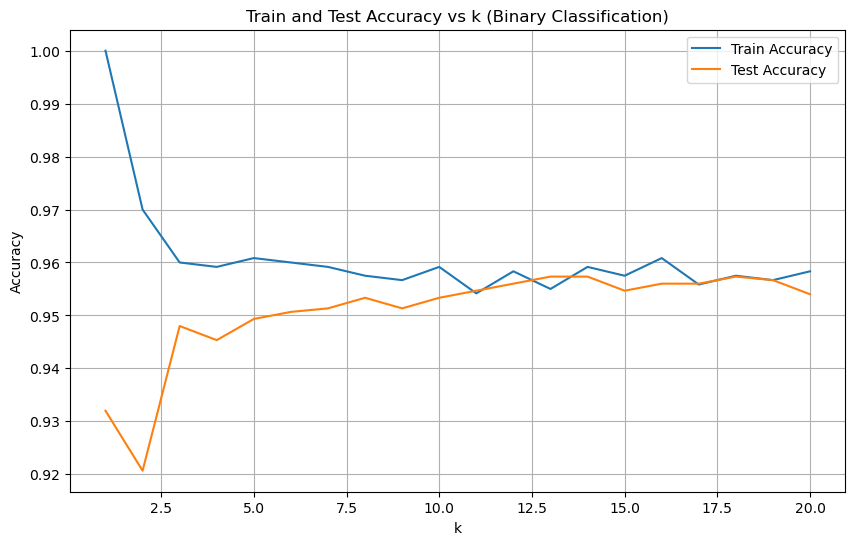

In [15]:
k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_cv, X_filtered_scaled, y, cv=5, scoring='accuracy')
    test_scores.append(cv_scores.mean())
    # Train score on full training set
    knn_cv.fit(X_train_filt, y_train)
    train_scores.append(knn_cv.score(X_train_filt, y_train))

# Plot train/test accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, label='Train Accuracy')
plt.plot(k_values, test_scores, label='Test Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs k (Binary Classification)')
plt.legend()
plt.grid(True)
plt.savefig('knn_accuracy_vs_k_binary.png')
plt.show()
plt.close()

Сравнение результатов до и после фильтрации признаков:
Фильтрация признаков может несколько снизить точность из-за потери информации, но упрощает модель.
Если показатели улучшаются, это говорит о том, что выбранные признаки захватывают наиболее значимую информацию.

## Многоклассовая классификация (stars в отзывах)


### Предобработка данных

Описание многоклассовой классификации:
Создал 3 класса на основе квантилей «длины»: Short, Medium, Long
Это моделирует проблему многоклассовой классификации, используя тот же набор данных.

In [18]:
print("Class distribution:\n", df['length_class'].value_counts())

Class distribution:
 length_class
Medium    508
Short     500
Long      492
Name: count, dtype: int64


In [20]:
X_multi = df.drop(['is_genuine', 'length_class', 'length'], axis=1)  # Exclude 'length' to avoid leakage
y_multi = df['length_class']

X_multi_scaled = scaler.fit_transform(X_multi)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi_scaled, y_multi, test_size=0.2, random_state=42)


### Обучение с нормализацией

In [ ]:
knn_multi = KNeighborsClassifier(n_neighbors=k)
knn_multi.fit(X_train_multi, y_train_multi)
y_pred_multi = knn_multi.predict(X_test_multi)

# Metrics
print("\nMulticlass Metrics:")
print(f"Accuracy: {accuracy_score(y_test_multi, y_pred_multi):.4f}")
print(f"Precision: {precision_score(y_test_multi, y_pred_multi, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_multi, y_pred_multi, average='weighted'):.4f}")
print(f"F1-score: {f1_score(y_test_multi, y_pred_multi, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_multi))


Multiclass Metrics:
Accuracy: 0.5900
Precision: 0.5869
Recall: 0.5900
F1-score: 0.5816

Classification Report:
              precision    recall  f1-score   support

        Long       0.41      0.52      0.46        86
      Medium       0.49      0.35      0.40       110
       Short       0.84      0.90      0.87       104

    accuracy                           0.59       300
   macro avg       0.58      0.59      0.58       300
weighted avg       0.59      0.59      0.58       300



### Отбор признаков

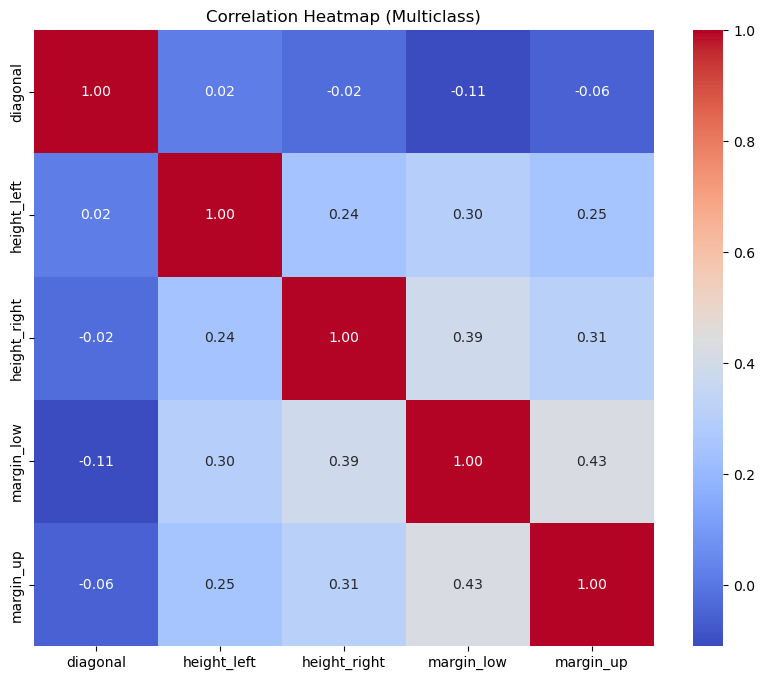

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_multi.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Multiclass)')
plt.savefig('correlation_heatmap_multi.png')
plt.show()
plt.close()

In [24]:
# Feature importance (correlation-based, simplified)
corr_matrix_multi = X_multi.corr().abs()
# Zero out diagonal
np.fill_diagonal(corr_matrix_multi.values, 0)
# Sum correlations for each feature
feature_importance_multi = corr_matrix_multi.sum().sort_values(ascending=False)
print("\nFeature importance (sum of absolute correlations):")
print(feature_importance_multi)

# Select top 3 features
top_features_multi = feature_importance_multi[:3].index.tolist()
print(f"Selected features: {top_features_multi}")

# Filter dataset
X_multi_filtered = X_multi[top_features_multi]
X_multi_filt_scaled = scaler.fit_transform(X_multi_filtered)
X_train_multi_filt, X_test_multi_filt, y_train_multi, y_test_multi = train_test_split(X_multi_filt_scaled, y_multi, test_size=0.2, random_state=42)



Feature importance (sum of absolute correlations):
margin_low      1.222021
margin_up       1.036232
height_right    0.958896
height_left     0.808615
diagonal        0.209115
dtype: float64
Selected features: ['margin_low', 'margin_up', 'height_right']


In [25]:
knn_multi_filt = KNeighborsClassifier(n_neighbors=k)
knn_multi_filt.fit(X_train_multi_filt, y_train_multi)
y_pred_multi_filt = knn_multi_filt.predict(X_test_multi_filt)

# Metrics
print("\nMulticlass Metrics with filtered features:")
print(f"Accuracy: {accuracy_score(y_test_multi, y_pred_multi_filt):.4f}")
print(f"Precision: {precision_score(y_test_multi, y_pred_multi_filt, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_multi, y_pred_multi_filt, average='weighted'):.4f}")
print(f"F1-score: {f1_score(y_test_multi, y_pred_multi_filt, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_multi_filt))



Multiclass Metrics with filtered features:
Accuracy: 0.5833
Precision: 0.5815
Recall: 0.5833
F1-score: 0.5784

Classification Report:
              precision    recall  f1-score   support

        Long       0.39      0.48      0.43        86
      Medium       0.49      0.38      0.43       110
       Short       0.83      0.88      0.86       104

    accuracy                           0.58       300
   macro avg       0.57      0.58      0.57       300
weighted avg       0.58      0.58      0.58       300



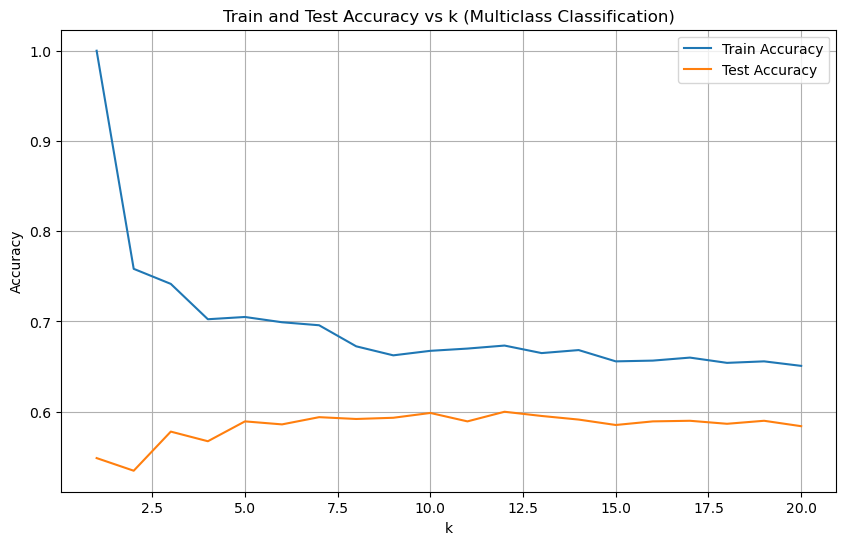

In [27]:
# 3.7 Cross-validation for k
train_scores_multi = []
test_scores_multi = []

for k in k_values:
    knn_cv_multi = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_cv_multi, X_multi_filt_scaled, y_multi, cv=5, scoring='accuracy')
    test_scores_multi.append(cv_scores.mean())
    knn_cv_multi.fit(X_train_multi_filt, y_train_multi)
    train_scores_multi.append(knn_cv_multi.score(X_train_multi_filt, y_train_multi))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores_multi, label='Train Accuracy')
plt.plot(k_values, test_scores_multi, label='Test Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs k (Multiclass Classification)')
plt.legend()
plt.grid(True)
plt.savefig('knn_accuracy_vs_k_multi.png')
plt.show()
plt.close()

In [29]:
# 3.8 Best classifier (using best k from cross-validation)
best_k = k_values[np.argmax(test_scores_multi)]
print(f"\nBest k for multiclass: {best_k}")
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_multi_filt, y_train_multi)
y_pred_best = knn_best.predict(X_test_multi_filt)


Best k for multiclass: 12


In [30]:
print("\nMetrics for best multiclass classifier:")
print(f"Accuracy: {accuracy_score(y_test_multi, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test_multi, y_pred_best, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_multi, y_pred_best, average='weighted'):.4f}")
print(f"F1-score: {f1_score(y_test_multi, y_pred_best, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_best))



Metrics for best multiclass classifier:
Accuracy: 0.5667
Precision: 0.5658
Recall: 0.5667
F1-score: 0.5612

Classification Report:
              precision    recall  f1-score   support

        Long       0.37      0.47      0.41        86
      Medium       0.48      0.35      0.41       110
       Short       0.82      0.88      0.85       104

    accuracy                           0.57       300
   macro avg       0.56      0.56      0.56       300
weighted avg       0.57      0.57      0.56       300



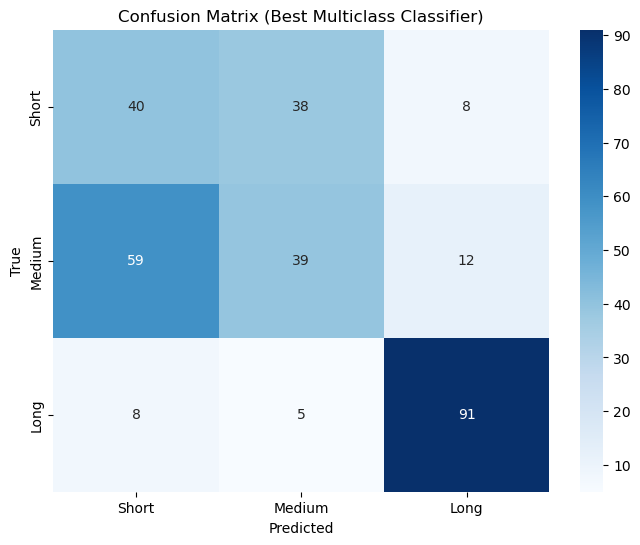

In [32]:
cm = confusion_matrix(y_test_multi, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Short', 'Medium', 'Long'], yticklabels=['Short', 'Medium', 'Long'])
plt.title('Confusion Matrix (Best Multiclass Classifier)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_multi.png')
plt.show()
plt.close()